In [1]:
!pip install plotly

In [2]:
#import all needed libraries
import numpy as np
from random import sample
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
import pandas as pd
import plotly.express as px
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

#COE426 Project

## Basic Algorithm of K-means.
- We will make this DP.
- **dont edit this code!** see below code.
- Reference https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

In [3]:
# this algorithm was modified so that it can be used for analysis it may have some bugs
def find_clusters(X, n_clusters, Initial_C):
    # 1. Randomly chooses clusters
    centers = Initial_C
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

##Data + Variables

You should edit this data section need to use the algorithm on different data set.

In [4]:
customers = pd.read_csv("https://raw.githubusercontent.com/ugis22/clustering_analysis/master/customers.csv") #get dataset and process it
Encode = {"Male":0, "Female":1}
customers["Gender"] = customers["Gender"].map(Encode)
X = customers.drop("CustomerID", axis=1) #X = data in dataframe form
D = X.to_numpy() #D = data in array form

n=2 #n will be used to generate n*k non-random centroids and it can be changed for testing. Please see the original paper for more information about this variable. 
k=5 #number of clusters

#For simplicity, we will define one domain of sensitive column. Our domain in this data set is the Annual Income (k$). it will be used for generating random centroids as paper states.
min_domain = X["Annual Income (k$)"].min()
high_domain = X["Annual Income (k$)"].max()
high_df = X[X["Annual Income (k$)"] == high_domain]
low_df = X[X["Annual Income (k$)"] == min_domain]
domain_array = high_df.append(low_df).to_numpy()

#Global Sensitivity Calculations as paper states
#r --> assume domain of data in a sphere between (-r, r)
#if the data is perfect, it will be between -r and r, and r will be = max or min, but this is not the case.
#to find r for data greater then zero do this: 
#1- add r, domain=(0,2r)
#2- add min value, domain=(min,2r+min)
#3- now, we know 2r+min=max, find r which is r=(max-min)/2
r = []
for i in range(D.shape[1]):
      r.append(((D[:,i].max()+1)-D[:,i].min())/2)
radius_a = 15 #A variable in the paper. it can be changed to generate different distanced-away points (centroids)
print("r = ", r)

r =  [1.0, 26.5, 61.5, 49.5]


#DP K-Means
- Reference Algorithm to implement: https://arxiv.org/pdf/2010.01234.pdf

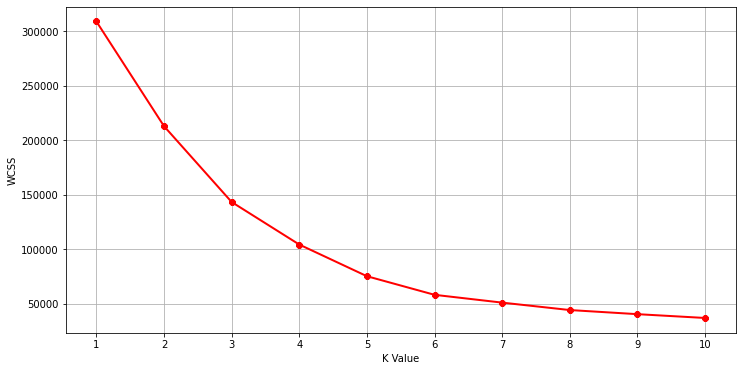

In [5]:
#To find optimal K - https://www.kaggle.com/cdabakoglu/clustering-mall-customers-k-means
#assume our K is 5 for mall customers data set. You need to set K for different data set based on this graph
wcss = []
for new_iter in range(1,11):
    kmeans = KMeans(n_clusters=new_iter, init="k-means++")
    kmeans.fit(X.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [6]:
def Generate_Centroids(D, n, k, domain_array, radius_a): #Generate Centroids Function based on Paper. Reference: End of this jupyter file.
  Centroid = np.zeros((0, D.shape[1]))
  while (len(Centroid) != n*k):
    random_data = []
    for i in range(D.shape[1]):
      random_data.append(np.random.randint(low=D[:,i].min(), high=D[:,i].max()+1))
    Random_Centroid = np.array([random_data])
    min_distance = np.min(cdist(Random_Centroid,domain_array))
    if ((min_distance>radius_a) and (len(Centroid)==0)):
      Centroid = np.vstack([Centroid, Random_Centroid])
    if (len(Centroid)!=0):
      min_distance = np.min(cdist(Random_Centroid,Centroid))
      if ((min_distance>2*radius_a)):
        Centroid = np.vstack([Centroid, Random_Centroid])
  return Centroid

In [7]:
def dp(D, k_clusters, n, domainlimit_r, Initial_C, e, max_clustering): #The algorithm of DP-Kmeans.
    """ DP K-Means 

    Args:
        D : Dataset in numpy array form
        k_clusters : number of clusters
        n : it's used to find k_clusters*n initial centroids to get a better chance for good initial centroids.
        domainlimit_r : radius of data for global sensitivity calculations
        Initial_C: intial centroids
        e : privacy budget
        max_clustering: the maximum number of iterations before returing the clusters.
    Returns:
        Two elements array. 
        [0]:numpy array of the cluster centroids.
        [1]:numpy array that maps every row in the dataset to centroid's index in [0]. (labeling of data)

    """
    # 1. Initial Private Random Centroids Selection
    r=domainlimit_r
    global_sen = np.array(r)*D.shape[1]+1
    privacybudget = e/max_clustering
    C = Initial_C

    for iter in range(max_clustering):
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(D, C)
        # 2b. Calculates Noise
        noise1=[]
        for i in range(D.shape[1]):
          noise1.append(np.random.laplace(global_sen[i]/privacybudget))
        noise2 = np.random.laplace(global_sen[i]/privacybudget)

        # 2c. Find new centers from means of points and add noise to them
        new_centers = np.array([((D[labels == i].sum(0)+noise1)/(len(D[labels == i])+noise2)) for i in range(k_clusters*n)])

        # 2d. Check for convergence
        if np.all(C == new_centers):
            break
        C = new_centers

    C = np.unique(C, axis=0)
    C_num = len(C)
    while C_num>k_clusters:
      # finding the two nearest clusters and combine them to C_o
      min_dist=float('inf')
      for p in range(C_num):
        for q in range(p+1,C_num):
          dist = np.linalg.norm(C[p]-C[q])
          if dist < min_dist:
            C_p=C[p]
            C_q=C[q]
            C_p_index=p
            C_q_index=q
            min_dist=dist
      C_o = []

      for i in range(D.shape[1]):
        if C_p[i] > C_q[i]:
          min_dimension=C_q[i]
          m=C_p_index
        else:
          min_dimension=C_p[i]
          m=C_q_index
        num_Cm = len(D[labels == m])
        num_Cp = len(D[labels == C_p_index])
        num_Cq = len(D[labels == C_q_index])
        C_o.append(min_dimension+abs(C_p[i]-C_q[i])*num_Cm/(num_Cp+num_Cq))
      
      C_o=np.array(C_o)
        
      # Deleting C_p from C and replace C_q with C_o
      C[C_q_index]=C_o
      C=np.delete(C, C_p_index, 0)
      
      C_num=C_num-1

      # assigning new labels to centers.

      labels = pairwise_distances_argmin(D, C)
    labels = pairwise_distances_argmin(D, C)
    return C, labels

In [8]:
n=2
init_cent = Generate_Centroids(D, n, k, domain_array, radius_a)

In [9]:
# if you get an error in the next line run the previous cell again and continue. The error happens because the initials centroids are not good.
centers_original, labels_original = find_clusters(D, k, init_cent)
print(centers_original)
print(labels_original)
centers_df, labels_df = dp(D, k, n, r, init_cent, 70, 3)
print(centers_df)
print(labels_df)

[[ 0.48648649 40.32432432 87.43243243 18.18918919]
 [ 0.59210526 43.93421053 55.21052632 49.44736842]
 [ 0.56       24.96       28.04       77.        ]
 [ 0.53846154 32.69230769 86.53846154 82.12820513]
 [ 0.60869565 45.2173913  26.30434783 20.91304348]]
[4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4
 2 4 2 4 2 4 2 4 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 0 3 1 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3
 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0
 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3]
[[ 0.35292628 32.90540548 70.54754406 14.70772388]
 [ 0.30214578 25.64389598 15.69826305 11.41296612]
 [ 0.36763941 18.9516647  22.30119393 56.93699222]
 [ 0.48879991 26.25681523 68.04584316 62.23351868]
 [ 0.51173068 44.04696878 45.88095025 41.87797153]]
[2 2 1 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 4 2 4 2 1 2 1 2 4 2 4 2 1 2 1 2 1 2 1
 2 4 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



## Visualize the data of K-means.

In [10]:
Encode = {0:"Group 1", 1:"Group 2", 2:"Group 3", 3:"Group 4", 4:"Group 5"}
labels_frame_original = pd.Series(data=labels_original).map(Encode)
fig = px.scatter_matrix(X, dimensions=["Age", "Annual Income (k$)", "Spending Score (1-100)"], color=labels_frame_original, title="Original K-Means Plots")
fig.update_layout(font_size=8)
fig.update_layout(legend_font_size=13)
fig.show()

In [11]:
labels_frame_df = pd.Series(data=labels_df).map(Encode)
fig = px.scatter_matrix(X, dimensions=["Age", "Annual Income (k$)", "Spending Score (1-100)"], color=labels_frame_df, title="DP K-Means Plots")
fig.update_layout(font_size=8)
fig.update_layout(legend_font_size=13)
fig.show()

In [12]:
fig = px.scatter_3d(X, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color=labels_frame_original, title="Normal K-Means 3D")
fig.update_layout(font_size=9)
fig.update_layout(legend_font_size=12)
fig.show()

In [13]:
fig = px.scatter_3d(X, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color=labels_frame_df, title="DP K-Means 3D")
fig.update_layout(font_size=9)
fig.update_layout(legend_font_size=12)
fig.show()

#Yousef Space


This section is done by Yousef. it will be used to analyze the result of DP-Kmeans algorithm. First, we will be generating synthatic data, even though it does not represent good data as original distribution, it will help in finding the error of different epsilon values. 

In [14]:
data = np.random.randint(0,2,size=1500)
dfgender = pd.DataFrame(data, columns=['Gender'])

data = np.random.randint(18,71,size=1500)
dfage = pd.DataFrame(data, columns=['Age'])

data = np.random.randint(15,138,size=1500)
dfincome = pd.DataFrame(data, columns=['Annual Income (k$)'])

data = np.random.randint(1,100,size=1500)
dfscore = pd.DataFrame(data, columns=['Spending Score (1-100)'])

dfgender['Age'] = dfage
dfgender['Annual Income (k$)'] = dfincome
dfgender['Spending Score (1-100)'] = dfscore

In [15]:
customers2 = customers.append(dfgender)
customers2 = customers2.drop("CustomerID", axis=1) #data in dataframe form
customers3 = customers2.sort_values('Annual Income (k$)')
customers3

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
405,1,61,15,8
406,1,47,15,78
483,0,21,15,75
603,1,61,15,86
...,...,...,...,...
1252,1,25,137,41
436,1,44,137,27
287,1,23,137,66
269,0,66,137,90


In [16]:
n2=3
radius_a2 = 20 #can be changed to generate different distance-away point
D2 = customers3.to_numpy() #data in array form

In [19]:
init_cent = Generate_Centroids(D2, n2, k, domain_array, radius_a2)
init_cent

array([[  0.,  23.,  40.,  48.],
       [  1.,  30., 125.,  42.],
       [  1.,  29.,  87.,  76.],
       [  1.,  53.,  99.,   1.],
       [  0.,  65.,  36.,  91.],
       [  0.,  68., 136.,  77.],
       [  1.,  58.,  16.,  21.],
       [  1.,  23.,  45.,  88.],
       [  1.,  61.,  61.,  33.],
       [  0.,  34.,  45.,   4.],
       [  1.,  24., 135.,  89.],
       [  1.,  64., 137.,   7.],
       [  1.,  70.,  91.,  91.],
       [  0.,  65., 101.,  51.],
       [  1.,  21.,  82.,  36.]])

In [20]:
# if you get an error in the next line run the previous two cells again and continue 
centers_original, labels_original = find_clusters(D2, k, init_cent) #0.1, 1, 5, 25, 50, 100 are all the epsilon values. 
centers_df_e1, labels_df_e1 = dp(D2, k, n2, r, init_cent, 0.1, 6)
centers_df_e2, labels_df_e2 = dp(D2, k, n2, r, init_cent, 1, 6)
centers_df_e3, labels_df_e3 = dp(D2, k, n2, r, init_cent, 5, 6)
centers_df_e4, labels_df_e4 = dp(D2, k, n2, r, init_cent, 25, 6)
centers_df_e5, labels_df_e5 = dp(D2, k, n2, r, init_cent, 50, 6)
centers_df_e6, labels_df_e6 = dp(D2, k, n2, r, init_cent, 100, 6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



In [21]:
Encode = {0:"Group 1", 1:"Group 2", 2:"Group 3", 3:"Group 4", 4:"Group 5"}
labels_frame_original = pd.Series(data=labels_original).map(Encode)
fig = px.scatter_matrix(customers3, dimensions=["Age", "Annual Income (k$)", "Spending Score (1-100)"], color=labels_frame_original, title="Original K-Means Plots")
fig.update_layout(font_size=8)
fig.update_layout(legend_font_size=13)
fig.show()

In [22]:
labels_frame_df = pd.Series(data=labels_df_e4).map(Encode)
fig = px.scatter_matrix(customers3, dimensions=["Age", "Annual Income (k$)", "Spending Score (1-100)"], color=labels_frame_df, title="DP K-Means Plots with e=25")
fig.update_layout(font_size=8)
fig.update_layout(legend_font_size=13)
fig.show()

In [23]:
fig = px.scatter_3d(customers3, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color=labels_frame_original, title="Normal K-Means 3D")
fig.update_layout(font_size=9)
fig.update_layout(legend_font_size=12)
fig.show()

In [24]:
fig = px.scatter_3d(customers3, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color=labels_frame_df, title="DP K-Means 3D with e=25")
fig.update_layout(font_size=9)
fig.update_layout(legend_font_size=12)
fig.show()

In [25]:
#function to calculate error based on distance of labels of original K-means and DP-Kmeans.
#it is specific to the data set used in this project file.
#the main idea of algorithm is to get the length(labels) for each centroids, 
#then put them in real numbers line, and find error of nearest len(labels) for each centroids in DP-Kmeans compared to original K-means
def Error_Labels(labels_original, labels_df):
  labelO0 = []
  labelO1 = []
  labelO2 = []
  labelO3 = []
  labelO4 = []
  for i in range (len(labels_original)):
    if (labels_original[i] == 0):
      labelO0.append(labels_original[i])
    elif (labels_original[i] == 1):
      labelO1.append(labels_original[i])
    elif (labels_original[i] == 2):
      labelO2.append(labels_original[i])
    elif (labels_original[i] == 3):
      labelO3.append(labels_original[i])
    else:
      labelO4.append(labels_original[i])

  arr_o = [len(labelO0), len(labelO1), len(labelO2), len(labelO3), len(labelO4)]


  labelDF0 = []
  labelDF1 = []
  labelDF2 = []
  labelDF3 = []
  labelDF4 = []
  for i in range (len(labels_df)):
    if (labels_df[i] == 0):
      labelDF0.append(labels_df[i])
    elif (labels_df[i] == 1):
      labelDF1.append(labels_df[i])
    elif (labels_df[i] == 2):
      labelDF2.append(labels_df[i])
    elif (labels_df[i] == 3):
      labelDF3.append(labels_df[i])
    else:
      labelDF4.append(labels_df[i])
  arr_df = [len(labelDF0), len(labelDF1), len(labelDF2), len(labelDF3), len(labelDF4)]

  error = 0
  while (len(arr_o) > 0):
    minDist = abs(arr_o[0] - arr_df[0])
    for i in range(len(arr_o)):
      for j in range(len(arr_df)):
        if (abs(arr_o[i] - arr_df[j]) <= minDist):
          minDist = abs(arr_o[i] - arr_df[j])
          e1 = i
          e2 = j
    init_error = (abs(arr_o[e1] - arr_df[e2]))**2
    error = error + init_error
    arr_o.remove(arr_o[e1])
    arr_df.remove(arr_df[e2])
  return error



In [26]:
label_error_e1 = Error_Labels(labels_original, labels_df_e1)
label_error_e2 = Error_Labels(labels_original, labels_df_e2)
label_error_e3 = Error_Labels(labels_original, labels_df_e3)
label_error_e4 = Error_Labels(labels_original, labels_df_e4)
label_error_e5 = Error_Labels(labels_original, labels_df_e5)
label_error_e6 = Error_Labels(labels_original, labels_df_e6)

In [27]:
#Store values in a Frame to Plot them. #0.1, 1, 5, 25, 50, 100
label_error = pd.DataFrame(data={'Epsilon':[0.1, 1, 5, 25, 50, 100],'Error':[label_error_e1, label_error_e2, label_error_e3, label_error_e4, label_error_e5, label_error_e6]})
label_error

,Epsilon,Error
0,0.1,2075612
1,1.0,2069476
2,5.0,1349654
3,25.0,101096
4,50.0,49904
5,100.0,95546


In [28]:
fig = px.line(label_error, x="Epsilon", y="Error", title="Error of Labels Difference over different number of Epsilon")
fig.show()

#Abdullah Space

def GenerateCentroid(radius a, Data d, n, k):
  - generate centroids randomely 1 by 1.
  -iterate n times, n=len(d).
    - Corners = Min_domain, Max_domain of every corner
    - K must be rad-a away from every point in Corners
    - K must be at least 2a away from any existing centroid.
    - Select different K if not satisfied.
  -centroid must be >= K, else decrease radius a and repeat.
  -return centroids.

Given a radius a, 
we randomly generate k centroids one by one such that each new centroid is of
distance at least rad-a away from every corner of the domain [−r, r]^d
and each new centroid is of distance at least 2a away from any existing centroid. When a randomly chosen point does not satisfy this
condition, we generate another point. When we have failed repeatedly, we conclude that the radius a is too large, and try a smaller
radius. We use a binary search to find the maximal value for a such
that it is the process of choosing k centroids succeed. This process
depends only on the shape of the overall domain and not where the
data points are, and thus does not affect privacy.


In [ ]:
C = np.array([[  1.,  52.,  37.,  32.],
              [  0.,  18., 135.,  98.]])

In [ ]:
#Unused algorithm that Finds smallest distance of a pair of points between n points in 2D array and report their indeces.
index_point1 = 0
min_distance = np.min(cdist(C[1:], np.reshape(C[0], (1,4))))
for i in range(len(C)-1):
  min_distance_loop = np.min(cdist(C[i+1:], np.reshape(C[i], (1,4))))
  if (min_distance_loop < min_distance):
    min_distance = min_distance_loop
    index_point1 = i+1
point1 = C[index_point1]
min_distance_array = cdist(C, np.reshape(point1, (1,4)))
min_distance_array = np.round(min_distance_array, 5)
min_distance = np.round(min_distance, 5)
index_point2 = np.where(min_distance_array==min_distance)
point2 = C[index_point2[0][0]]
print("point 1:", point1, "point 2:", point2)
print("minimum distance between all points: ", min_distance) #can confirm they are point 1 and point 2 using this calculator: https://www.omnicalculator.com/math/distance